<a href="https://colab.research.google.com/github/Benyormin/dimensionality-reduction/blob/main/dimensionality_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install  datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
from transformers import BertModel
import torch
import torch.nn as nn
import torch.nn.functional as F



In [3]:
!git clone https://github.com/Benyormin/fineTuneBert.git

Cloning into 'fineTuneBert'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 132 (delta 3), reused 0 (delta 0), pack-reused 116
Receiving objects: 100% (132/132), 713.09 KiB | 5.61 MiB/s, done.
Resolving deltas: 100% (64/64), done.


In [5]:
# your config goes here
path = '/content/fineTuneBert/CR_Dataset/'
BATCH_SIZE = 64
learning_rate = 1e-5
num_epochs = 6
printFreq = 24

In [6]:
from datasets import load_from_disk
import os

def load_dataset_fold(num_fold, dir= path):
  if(num_fold <=0 or num_fold>10):
    return "it's 10 fold cross-validation please enter valid number in range 1-10!"
  dataset = load_from_disk(os.path.join(path, f"fold-{num_fold}-CR"))
  return dataset


In [7]:
dataset = load_dataset_fold(5)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 3052
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 340
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 377
    })
})

#Preprocess

The next step is to load a BERT tokenizer to preprocess the `text` field

In [8]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [9]:
def tokenize_function(examples):
  '''
  Preprocesses the input examples for the NLP model.

    Args:
        examples (List[Dict]): A list of input examples, where each example is a dictionary
            containing the following keys:
                - "sentence": The text of the example.

    Returns:
        Dict: A dictionary containing the preprocessed examples.
  '''
  return tokenizer(examples["text"],  truncation=True, max_length= 256 )

train_tokenized = dataset['train'].map(tokenize_function, batched = True)
valid_tokenized = dataset['validation'].map(tokenize_function, batched = True)
test_tokenized = dataset['test'].map(tokenize_function, batched = True)


Map:   0%|          | 0/3052 [00:00<?, ? examples/s]

Map:   0%|          | 0/340 [00:00<?, ? examples/s]

Map:   0%|          | 0/377 [00:00<?, ? examples/s]

In [10]:
train_tokenized.set_format('torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
valid_tokenized.set_format('torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
test_tokenized.set_format('torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
train_tokenized, valid_tokenized, test_tokenized

(Dataset({
     features: ['text', 'label', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 3052
 }),
 Dataset({
     features: ['text', 'label', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 340
 }),
 Dataset({
     features: ['text', 'label', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 377
 }))

In [11]:
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

data_collator = DataCollatorWithPadding(tokenizer= tokenizer)

train_dataloader = DataLoader(train_tokenized, batch_size= BATCH_SIZE, shuffle=True, collate_fn=data_collator)
valid_dataloader = DataLoader(valid_tokenized, batch_size= BATCH_SIZE, shuffle= True, collate_fn= data_collator)
test_dataloader = DataLoader(test_tokenized, batch_size= BATCH_SIZE, shuffle=True, collate_fn= data_collator)

## Model

In [54]:
class Bert(nn.Module):
  def __init__(self, checkpoint, num_class):

    super(Bert, self).__init__()
    self.bertModel = BertModel.from_pretrained(checkpoint)
    self.dpLayer = nn.Dropout(0.1)
    self.classifier = nn.Linear(self.bertModel.config.hidden_size, num_class) #768,2

  def forward(self, input_ids, token_type_ids, attention_mask, labels=None):
    output = self.bertModel(input_ids= input_ids, attention_mask= attention_mask, token_type_ids= token_type_ids)
    CLS = output[0][:, 0, :].view(-1, 768)
    logits = self.classifier(self.dpLayer(CLS))
    return{
        'feature': CLS,
        'logits': logits

    }


In [55]:
model = Bert("bert-base-uncased", 2)
model

Bert(
  (bertModel): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

## Loss function

In [56]:
criterion = nn.CrossEntropyLoss()


## optimizer & Learning rate Scheduler

In [57]:
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
from transformers import get_scheduler

num_training_steps = num_epochs*len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

In [58]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [59]:
model.to(device)

Bert(
  (bertModel): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

In [60]:
import matplotlib.pyplot as plt
def plot_data(feat_pca, labels, title):
  '''
  feature_pca : bs,2
  labels : bs
  '''

  feat_plot1 = np.array([])
  feat_plot0 = np.array([])

  feat_plot1 = feat_pca[labels == 1]
  feat_plot0 = feat_pca[labels == 0]
  #plot by truth labels
  plt.scatter(feat_plot1[:,0], feat_plot1[:, 1], color='green')
  plt.scatter(feat_plot0[:,0], feat_plot0[:, 1], color='red')
  plt.title(title)
  plt.xlabel('x')
  plt.ylabel('y')
  plt.show()

In [61]:
def train_epoch(train_dataloader, model, epoch, num_epochs, device):
  """
  Trains the provided model for a single epoch using the given training data loader.

  Args:
    train_dataloader (DataLoader): The DataLoader object containing the training data batches.
    model (torch.nn.Module): The model to be trained.
    accelerator (Accelerator): The accelerator object responsible for distributed training acceleration.
    epoch (int): The current epoch number.
    num_epochs (int): The total number of epochs for training.
    device (torch.device): The device (e.g., 'cuda' or 'cpu') on which the model is being trained.

  Returns:
    float: The average loss over all batches in the epoch.
  """

  epoch_loss = 0.0
  model.train()
  for idx, batch in enumerate(train_dataloader):
    batch = {k:v.to(device) for k,v in batch.items()}
    output = model(**batch)
    loss = criterion(output['logits'], batch['labels'])
    epoch_loss += loss.item()
    #back prop
    loss.backward()
    #update parameters
    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()
    progress_bar.update(1)
    if(idx % printFreq == 0):
      print(f"epoch {epoch+1}/{num_epochs} --> iteration {idx}, loss for last batch: {loss}")

  print(f"average_loss = {epoch_loss / len(train_dataloader)}")
  return epoch_loss/len(train_dataloader)


In [62]:
from sklearn.metrics import f1_score, accuracy_score
def validate_epoch(valid_dataloader, model, epoch, num_epochs, device):
   """
    Validates the performance of the model on the validation dataset for a single epoch.

    Args:
        valid_dataloader (DataLoader): The DataLoader object containing the validation data batches.
        model (torch.nn.Module): The model to be validated.
        accelerator (Accelerator): The accelerator object responsible for distributed training acceleration.
        epoch (int): The current epoch number.
        num_epochs (int): The total number of epochs for training.
        device (torch.device): The device (e.g., 'cuda' or 'cpu') on which the model is being trained.

    Returns:
        tuple: A tuple containing the accuracy, F1 score, and average loss for the epoch.
   """

   true_labels = []
   predicted_labels = []
   epoch_loss = 0.0
   kmean_acc = 0.0

   model.eval()

   for idx, batch in enumerate(valid_dataloader):

    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():

      outputs = model(**batch)
      loss = criterion(outputs['logits'], batch['labels'])

      epoch_loss +=loss.item()

      ## calculate acc
      labels = batch.pop('labels')
      softmax_output = torch.nn.functional.softmax(outputs['logits'], dim=1)
      y_pred = softmax_output.argmax(dim=1)

      # Convert tensors to numpy arrays and append to the lists
      true_labels.extend(labels.cpu())
      predicted_labels.extend(y_pred.cpu())

      k = kmean(outputs['feature'].cpu(), labels.cpu(), "minmax")
      km_acc, yp = k.calculate()
      kmean_acc += km_acc



   accuracy = accuracy_score(true_labels, predicted_labels)
   f1 = f1_score(true_labels, predicted_labels)
   avg_loss = epoch_loss /len(valid_dataloader)
   kmean_acc /= len(valid_dataloader)

   ##plot last batch in the epoch
   plot_data(k.feat , labels.cpu(),"by truth labels")
   plot_data(k.feat , torch.tensor(yp),"by predicted labels")


   print(f"epoch {epoch+1}/{num_epochs} results on validation acc:{accuracy}, f1:{f1}, avg_loss:{avg_loss} ")
   print(f"K mean accuracy:  {kmean_acc} ")
   return accuracy, f1, avg_loss, kmean_acc



In [63]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler



class kmean:

  def __init__(self, feat, truth_labels, method):
    self.km = KMeans(n_clusters=2, n_init=10)
    self.truth_labels = truth_labels
    self.method = method
    self.feat = feat
    self.scale()
    #reduce dimentions
    pca = PCA(n_components= 2)
    self.feat = pca.fit_transform(feat.detach().numpy())

    self.yp = self.fit()

  def scale(self):
    if self.method == "minmax":
      scaler = MinMaxScaler()
      scaler.fit(self.feat.detach().numpy())
      self.feat = scaler.transform(self.feat.detach().numpy())

    if self.method == "standard":
      scaler = StandardScaler()
      scaler.fit(self.feat.detach().numpy())
      self.feat = scaler.transform(self.feat.detach().numpy())

    if self.method == "robust":
      rb_scaler = RobustScaler()
      rb_scaler.fit(self.feat.detach().numpy())
      self.feat = rb_scaler.transform(self.feat.detach().numpy())



  def fit(self):
    yp = self.km.fit_predict(self.feat)
    return yp

  def accuracy(self, predicted_labels):
    n_correct = 0
    for data in range(len(self.truth_labels)):
      if self.truth_labels[data].item() == predicted_labels[data]:
        n_correct +=1


    return n_correct / len(self.truth_labels)

  def complement_array(self, array):
    complemented_array = [1 - x for x in array]
    return complemented_array

  def calculate(self):
    acc1 = self.accuracy(self.yp)
    ypComplement = self.complement_array(self.yp)
    acc2 = self.accuracy(ypComplement)

    if acc1 >= acc2:
      return acc1, self.yp
    else:
      return acc2, ypComplement







## Training Loop

  0%|          | 0/288 [00:00<?, ?it/s]

epoch 1/6 --> iteration 0, loss for last batch: 0.6621465682983398
epoch 1/6 --> iteration 24, loss for last batch: 0.4751579463481903
average_loss = 0.47406245209276676


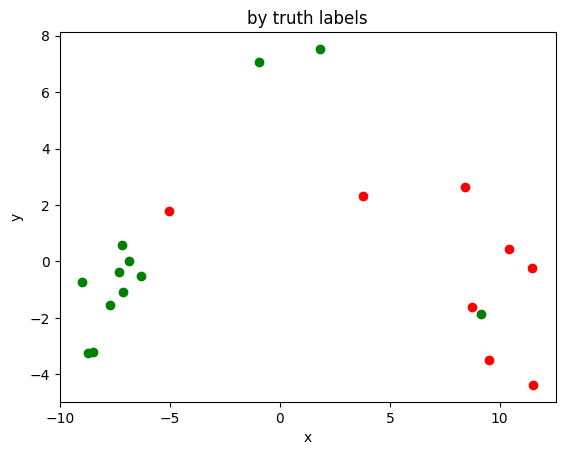

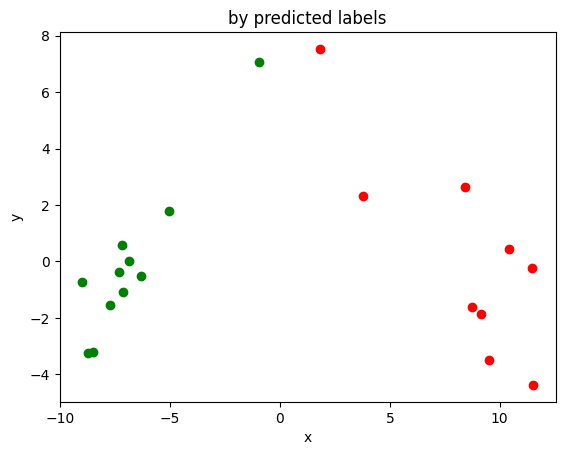

epoch 1/6 results on validation acc:0.9, f1:0.925764192139738, avg_loss:0.28377047429482144 
K mean accuracy:  0.8916666666666666 
saving best model to 'best_model.pth'... 
epoch 2/6 --> iteration 0, loss for last batch: 0.26725608110427856
epoch 2/6 --> iteration 24, loss for last batch: 0.1801455169916153
average_loss = 0.22384833466882506


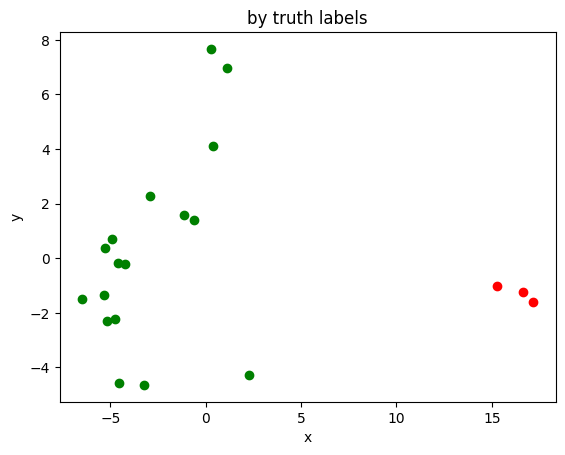

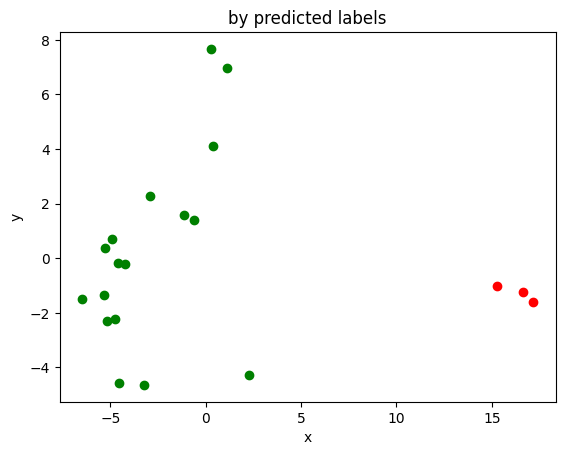

epoch 2/6 results on validation acc:0.9176470588235294, f1:0.9385964912280702, avg_loss:0.23060888176163039 
K mean accuracy:  0.9296875 
saving best model to 'best_model.pth'... 
epoch 3/6 --> iteration 0, loss for last batch: 0.16695058345794678
epoch 3/6 --> iteration 24, loss for last batch: 0.09516015648841858
average_loss = 0.13665409789731106


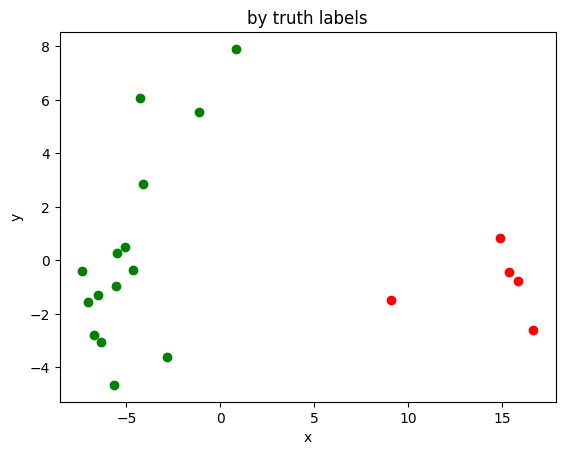

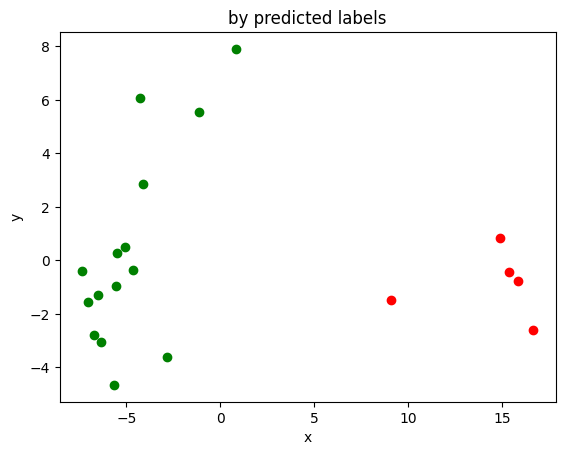

epoch 3/6 results on validation acc:0.9205882352941176, f1:0.9395973154362416, avg_loss:0.26185035270949203 
K mean accuracy:  0.9114583333333334 
saving best model to 'best_model.pth'... 
epoch 4/6 --> iteration 0, loss for last batch: 0.052235525101423264
epoch 4/6 --> iteration 24, loss for last batch: 0.06854740530252457
average_loss = 0.08133964842030157


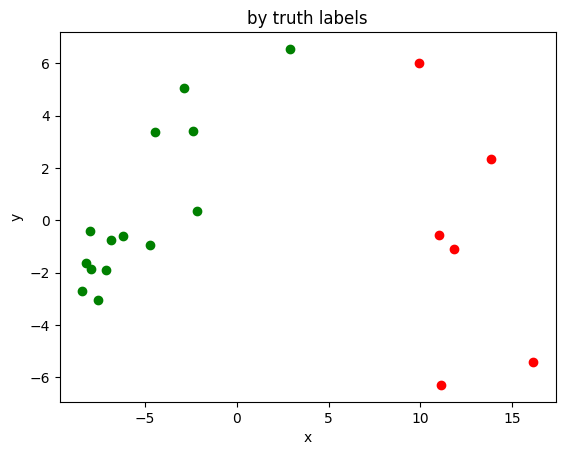

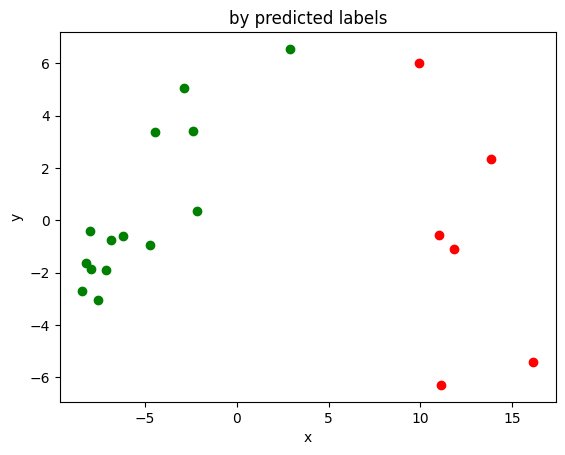

epoch 4/6 results on validation acc:0.9117647058823529, f1:0.9330357142857142, avg_loss:0.27539303774635 
K mean accuracy:  0.9140625 
epoch 5/6 --> iteration 0, loss for last batch: 0.023410096764564514
epoch 5/6 --> iteration 24, loss for last batch: 0.07202194631099701
average_loss = 0.050598512830523155


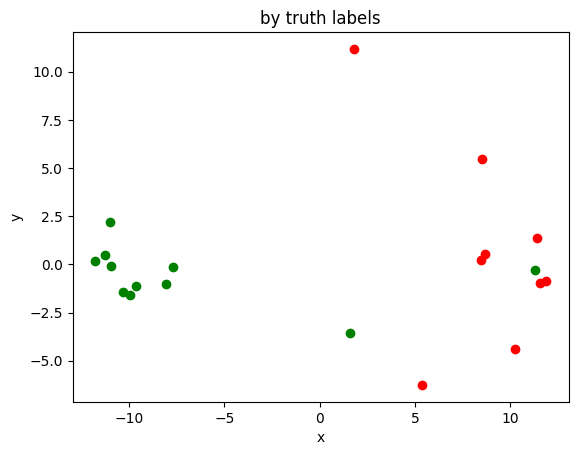

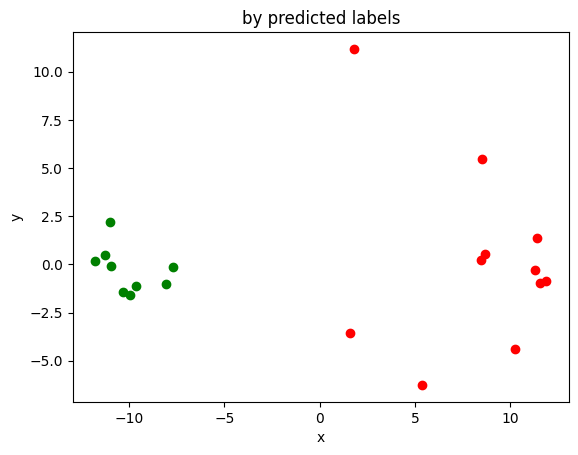

epoch 5/6 results on validation acc:0.9117647058823529, f1:0.9336283185840707, avg_loss:0.35629268859823543 
K mean accuracy:  0.9052083333333334 
epoch 6/6 --> iteration 0, loss for last batch: 0.018462710082530975
epoch 6/6 --> iteration 24, loss for last batch: 0.010802478529512882
average_loss = 0.025790632906137034


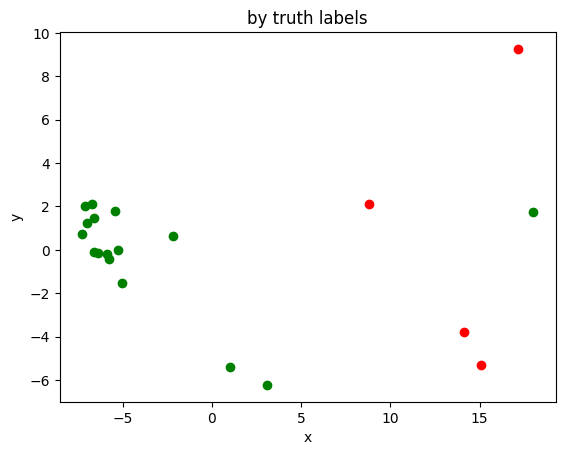

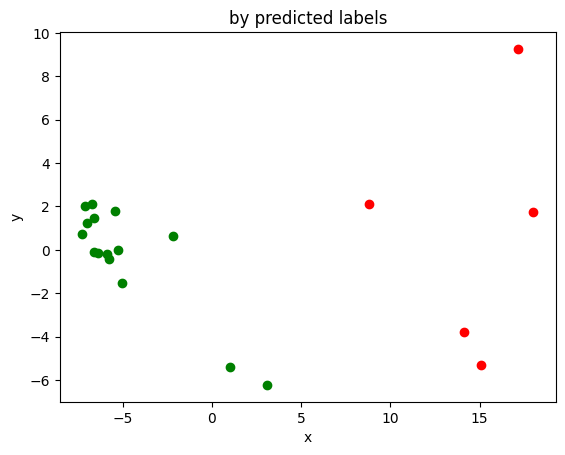

epoch 6/6 results on validation acc:0.8911764705882353, f1:0.9197396963123645, avg_loss:0.39685581624507904 
K mean accuracy:  0.9031250000000001 
Best validation Accuracy : 0.9206
Best model saved as 'best_model.pth'


In [64]:
from tqdm.auto import tqdm
progress_bar = tqdm(range(num_training_steps))

trian_epoch_loss = []
valid_epoch_acc = []
kmAccuracy = []
total_loss = 0.0
best_accuracy = 0.0
patience = 4

for epoch in range(num_epochs):
  avg_train_loss = train_epoch(train_dataloader, model, epoch, num_epochs, device)
  acc, f1, avg_valid_loss, kmean_acc = validate_epoch(valid_dataloader, model, epoch, num_epochs, device)
  kmAccuracy.append(kmean_acc)
  valid_epoch_acc.append(acc)


  if(acc> best_accuracy):
    best_accuracy = acc
    early_stopping_counter = 0
    torch.save(model.state_dict(), f'best_model.pth')
    print("saving best model to 'best_model.pth'... ")

  else:
      early_stopping_counter += 1
      if early_stopping_counter >= patience:
          print(f"Early stopping: No improvement in {patience} epochs.")
          break

print(f"Best validation Accuracy : {best_accuracy:.4f}")
print("Best model saved as 'best_model.pth'")



## Test

In [65]:
import torch
from sklearn.metrics import f1_score, accuracy_score

true_labels= []
predicted_labels= []
for batch in test_dataloader:
  batch = {k:v.to(device) for k,v in batch.items()}
  t_labels = batch.pop('labels')

  model.eval()
  with torch.no_grad():

    outputs = model(**batch)

    softmax_output = torch.nn.functional.softmax(outputs['logits'], dim=1)
    y_pred = softmax_output.argmax(dim=1)

    # Convert tensors to numpy arrays and append to the lists
    true_labels.extend(t_labels.cpu())
    predicted_labels.extend(y_pred.cpu())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("F1 Score:", f1)

Accuracy: 0.896551724137931
F1 Score: 0.9202453987730062
